In [1]:
import sys
sys.path.append('../') 

import MetaTrader5 as mt5
import pytz
import numpy as np
import pandas_ta as ta
import pandas as pd
import math

from datetime import datetime
from terminal.Extensions.Mt5Helper import Mt5Helper
from renko import Renko


In [30]:
mt5.initialize()

True

In [31]:
slippage = 5
brick_size = 15

from_date = datetime(2024, 5, 27, tzinfo=pytz.utc)
to_date = datetime(from_date.year, from_date.month, from_date.day, 23, 59, 59, 0, tzinfo=pytz.utc)
data = mt5.copy_ticks_range('WINM24', from_date, to_date, mt5.COPY_TICKS_TRADE)

rates = Mt5Helper.OHLC(data, '2500ms')
rates.index = rates.index.tz_localize(None)

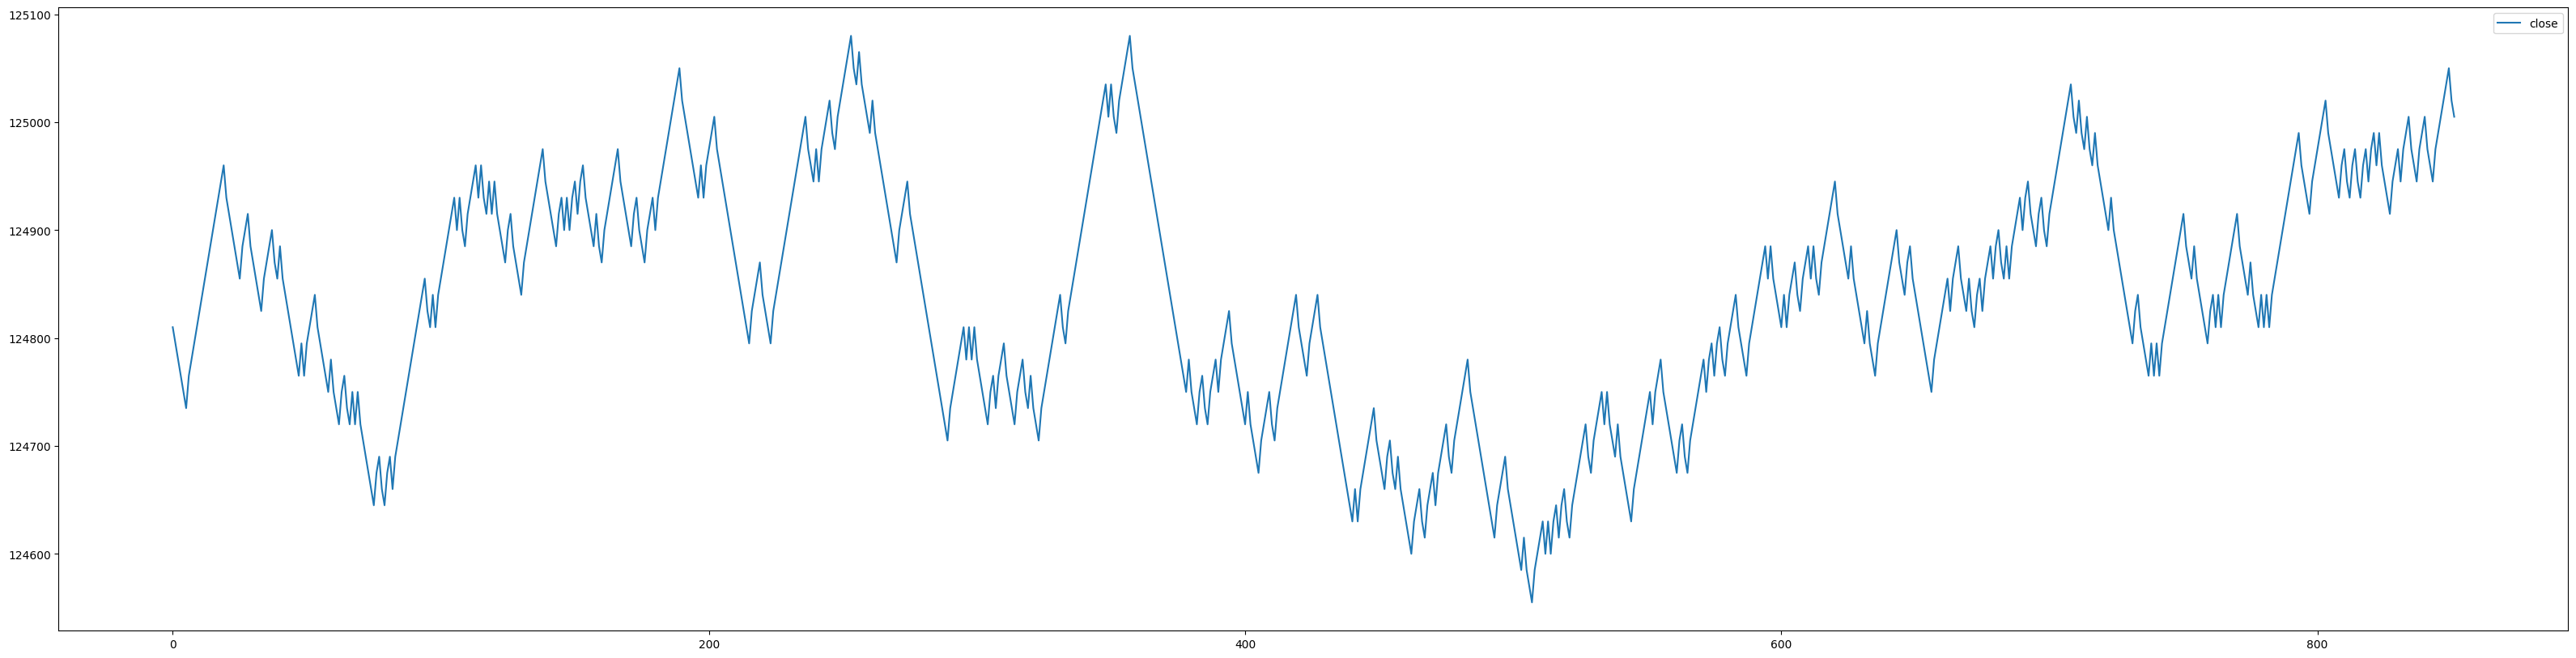

In [38]:
renko = Renko(brick_size=brick_size, data=rates.iloc[:]["open"])
renko.create_renko()
renko_ohlc = pd.DataFrame(renko.bricks)
renko_ohlc[["close"]].plot(figsize=(40,10))
renko_ohlc.to_excel("output.xlsx")

<Axes: xlabel='time_msc'>

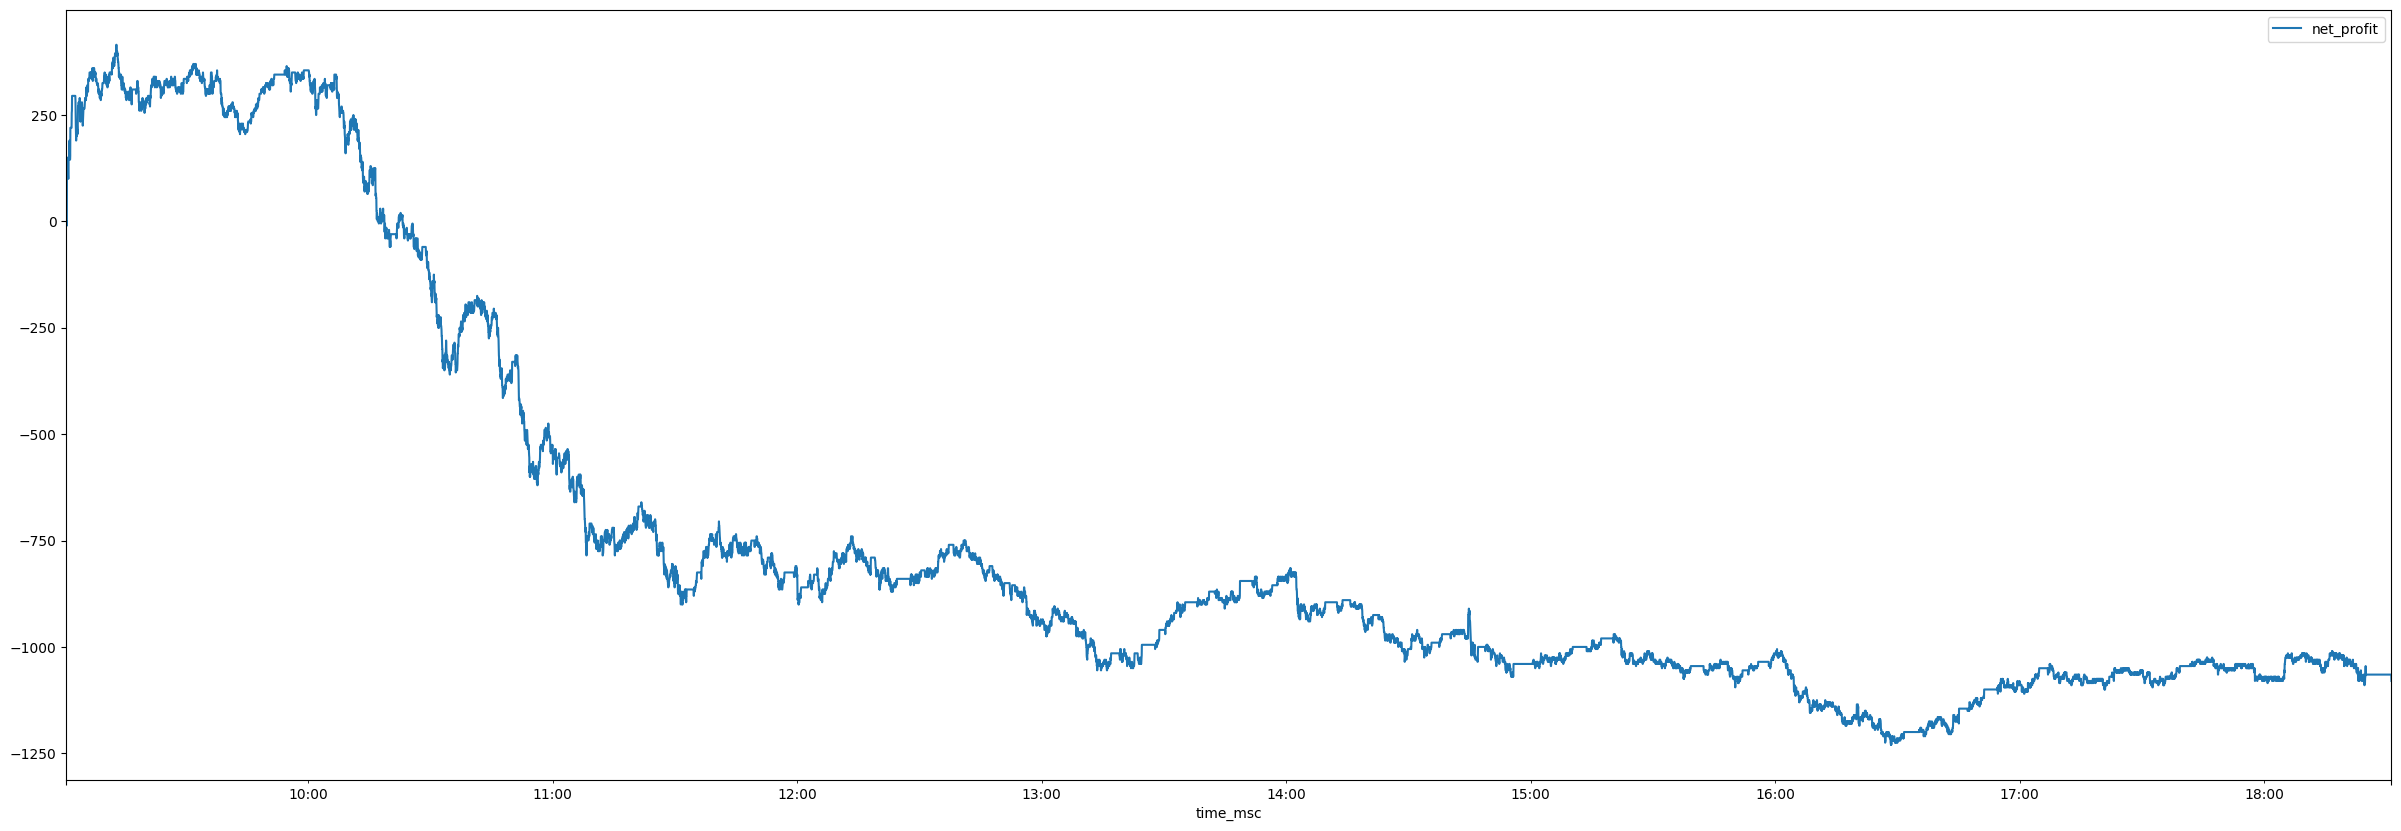

In [33]:
sum_buy = 0
buy_qty = 0
buy_avg = 0
buy_profit = 0

sum_sell = 0
sell_qty = 0
sell_avg = 0
sell_profit = 0

net_qty = 0
net_profit = 0

used_slippage = 0


def update(i):
    rates.loc[i, "sum_buy"] = sum_buy
    rates.loc[i, "buy_qty"] = buy_qty
    rates.loc[i, "buy_avg"] = buy_avg
    rates.loc[i, "buy_profit"] = buy_profit
    rates.loc[i, "sum_sell"] = sum_sell
    rates.loc[i, "sell_qty"] = sell_qty
    rates.loc[i, "sell_avg"] = sell_avg
    rates.loc[i, "sell_profit"] = sell_profit
    rates.loc[i, "net_qty"] = net_qty
    rates.loc[i, "net_profit"] = net_profit
    rates.loc[i, "slippage"] = used_slippage


renko = None
count = 0

for i, item in rates.iterrows():
    if np.isnan(item.open):
        update(i)
        continue

    used_slippage = slippage

    if renko is None:
        renko = Renko(brick_size=brick_size, data=rates.loc[:i].iloc[-1:]["open"])
        renko.create_renko()
    else: 
        renko.check_new_price(item["open"])
    
    renko_ohlc = pd.DataFrame(renko.bricks)

    if not renko_ohlc.empty and count != renko_ohlc.count()["type"]:
        if renko_ohlc.iloc[-1]["type"] == "down" and net_qty <= 0:
            qty = 1

            if net_qty < 0:
                qty = 2
            
            sum_buy += qty * (item.open + used_slippage)
            buy_qty += qty

        if renko_ohlc.iloc[-1]["type"] == "up" and net_qty >= 0:
            qty = 1
            
            if net_qty < 0:
                qty = 2
                
            sum_sell += qty * (item.open - used_slippage)
            sell_qty += qty

    count = renko_ohlc.count()["type"]
    
    buy_avg = 0 if sum_buy == 0 else sum_buy / buy_qty
    sell_avg = 0 if sum_sell == 0 else sum_sell / sell_qty

    buy_profit = 0 if buy_qty == 0 else (item.open - used_slippage - buy_avg) * buy_qty
    sell_profit = (
        0 if sell_qty == 0 else (sell_avg - item.open + used_slippage) * sell_qty
    )

    net_qty = buy_qty - sell_qty
    net_profit = buy_profit + sell_profit

    update(i)


rates.iloc[:][["net_profit"]].plot(figsize=(30, 10))

In [34]:
rates.to_excel("output_result.xlsx")